# Stacking

## How does stacking work?

1) Generate a Meta-Model - from predictions of set of weak learners (using k-fold cv)

2) Train the Meta-Model with a final estimator (a ML model)


### Steps:

Level-0: use weak learners to generate training data for the meta-model. 'Stack' the prediction from each weak learners and that became the training set of the Meta Model

Level-1: Train the meta-model

### Code Example from Medium-Fernando López 

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

class Ensemble:
    def __init__(self):
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.k = 5

    def load_data(self):
        x, y = load_breast_cancer(return_X_y=True)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.3, random_state=23)
    
    def StackingClassifier(self):

        # Define weak learners
        weak_learners = [('dt', DecisionTreeClassifier()),
                        ('knn', KNeighborsClassifier()),
                        ('rf', RandomForestClassifier()),
                        ('gb', GradientBoostingClassifier()),
                        ('gn', GaussianNB())]
        
        # Finaler learner or meta model
        final_learner = LogisticRegression()

        train_meta_model = None
        test_meta_model = None

        # Start stacking
        for clf_id, clf in weak_learners:
            # Predictions for each classifier based on k-fold
            predictions_clf = self.k_fold_cross_validation(clf)
            
            # Predictions for test set for each classifier based on train of level 0
            test_predictions_clf = self.train_level_0(clf)
            
            # Stack predictions which will form 
            # the inputa data for the data model
            if isinstance(train_meta_model, np.ndarray):
                train_meta_model = np.vstack((train_meta_model, predictions_clf))
            else:
                train_meta_model = predictions_clf

            # Stack predictions from test set
            # which will form test data for meta model
            if isinstance(test_meta_model, np.ndarray):
                test_meta_model = np.vstack((test_meta_model, test_predictions_clf))
            else:
                test_meta_model = test_predictions_clf
        
        # Transpose train_meta_model
        train_meta_model = train_meta_model.T

        # Transpose test_meta_model
        test_meta_model = test_meta_model.T
        
        # Training level 1
        self.train_level_1(final_learner, train_meta_model, test_meta_model)


    def k_fold_cross_validation(self, clf):
        
        predictions_clf = None

        # Number of samples per fold
        batch_size = int(len(self.x_train) / self.k)

        # Stars k-fold cross validation
        for fold in range(self.k):

            # Settings for each batch_size
            if fold == (self.k - 1):
                test = self.x_train[(batch_size * fold):, :]
                batch_start = batch_size * fold
                batch_finish = self.x_train.shape[0]
            else:
                test = self.x_train[(batch_size * fold): (batch_size * (fold + 1)), :]
                batch_start = batch_size * fold
                batch_finish = batch_size * (fold + 1)
            
            # test & training samples for each fold iteration
            fold_x_test = self.x_train[batch_start:batch_finish, :]
            fold_x_train = self.x_train[[index for index in range(self.x_train.shape[0]) if index not in range(batch_start, batch_finish)], :]

            # test & training targets for each fold iteration
            fold_y_test = self.y_train[batch_start:batch_finish]
            fold_y_train = self.y_train[[index for index in range(self.x_train.shape[0]) if index not in range(batch_start, batch_finish)]]

            # Fit current classifier
            clf.fit(fold_x_train, fold_y_train)
            fold_y_pred = clf.predict(fold_x_test)

            # Store predictions for each fold_x_test
            if isinstance(predictions_clf, np.ndarray):
                predictions_clf = np.concatenate((predictions_clf, fold_y_pred))
            else:
                predictions_clf = fold_y_pred

        return predictions_clf

    def train_level_0(self, clf):
        # Train in full real training set
        clf.fit(self.x_train, self.y_train)
        # Get predictions from full real test set
        y_pred = clf.predict(self.x_test)
        
        return y_pred

    def train_level_1(self, final_learner, train_meta_model, test_meta_model):
        # Train is carried out with final learner or meta model
        final_learner.fit(train_meta_model, self.y_train)
        # Getting train and test accuracies from meta_model
        print(f"Train accuracy: {final_learner.score(train_meta_model,  self.y_train)}")
        print(f"Test accuracy: {final_learner.score(test_meta_model, self.y_test)}")
        

if __name__ == "__main__":
    ensemble = Ensemble()
    ensemble.load_data()
    ensemble.StackingClassifier()

Train accuracy: 0.9522613065326633
Test accuracy: 0.9707602339181286


### Code Example from DataWhale

In [6]:
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
RANDOM_SEED = 42

#3 weak learners
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()


sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], # Level-0 Classifier                            
meta_classifier=lr, # Level-1 Classifier
random_state=RANDOM_SEED)
print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'NaiveBayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [NaiveBayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


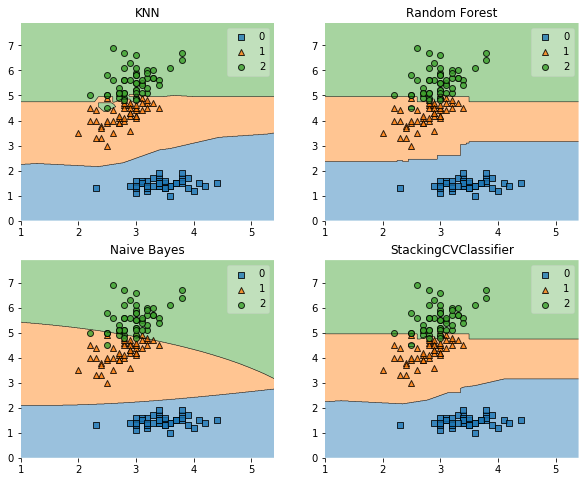

In [9]:
#Decision Boundary
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.pyplot as plt

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf],['KNN','Random Forest','Naive Bayes','StackingCVClassifier'],itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

### Dealing with Probabilities

When using 'probability' as training set: Add use_probas = True and average_probas = True, otherwise all the values will be appended.


In [12]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
use_probas=True, #
meta_classifier=lr,
random_state=42)
print('3-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3, sclf],['KNN','Random Forest','Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


### 5-Fold CV with GridSearch CV

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier
# Initializing models
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], #Weak learners
meta_classifier=lr, #Meta-model
random_state=42)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
'randomforestclassifier__n_estimators': [10, 50],
'meta_classifier__C': [0.1, 10.0]}

#Gridsearch CV
grid = GridSearchCV(estimator=sclf, 
param_grid=params,
cv=5,
refit=True)

grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"% (grid.cv_results_[cv_keys[0]][r], grid.cv_results_[cv_keys[1]][r] / 2.0, grid.cv_results_[cv_keys[2]][r]))
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.947 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.933 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In [15]:
from sklearn.model_selection import GridSearchCV
# Initializing models
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf1, clf2, clf3],
meta_classifier=lr,
random_state=RANDOM_SEED)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
'kneighborsclassifier-2__n_neighbors': [1, 5],
'randomforestclassifier__n_estimators': [10, 50],
'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf,
param_grid=params,
cv=5,
refit=True)

grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r" % (grid.cv_results_[cv_keys[0]][r], grid.cv_results_[cv_keys[1]][r] / 2.0, grid.cv_results_[cv_keys[2]][r]))
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.960 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestcla

### Pipeline

In [20]:
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)), # Column 0,2
LogisticRegression())


pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)), # Column 1,2,3
LogisticRegression())

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2],
meta_classifier=LogisticRegression(),
random_state=42)

sclf.fit(X, y)


StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 2))),
                                                  ('logisticregression',
                                                   LogisticRegression())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(1, 2,
                                                                        3))),
                                                  ('logisticregression',
                                                   LogisticRegression())])],
                     meta_classifier=LogisticRegression(), random_state=42)

### ROC 

Text(0.5, 1.0, 'Receiver operating characteristic example')

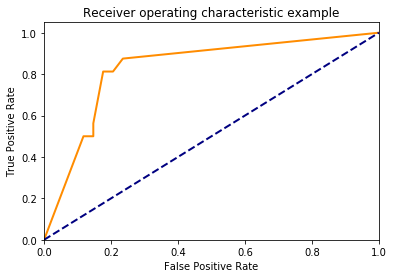

In [21]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=RANDOM_SEED)
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
meta_classifier=lr)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

References:
    
Ensemble Learning: Stacking, Blending & Voting: https://towardsdatascience.com/ensemble-learning-stacking-blending-voting-b37737c4f483

Datawhale: https://github.com/datawhalechina/team-learning-data-mining/tree/master/EnsembleLearning